# üéØ Weekend Effect Analysis

**Objectif**: Analyser l'impact du weekend sur les patterns de rating et d√©couvrir les rythmes comportementaux des utilisateurs.

## üîç Questions exploratoires:
- Les gens notent-ils diff√©remment quand ils ont du temps libre ?
- Quel est le "jour le plus dur" vs "jour le plus cool" ?
- Le weekend change-t-il la FORME des distributions de ratings ?
- L'effet weekend √©volue-t-il dans le temps ?
- Quels sont les rythmes naturels d'usage de la plateforme ?

In [67]:
# Imports et chargement utilitaires
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

# üéØ Chargement des fonctions utilitaires depuis le fichier Python (plus robuste)
from data_utils import *

# Imports sp√©cifiques analyses
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, chi2_contingency, kruskal
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("‚úÖ Imports termin√©s - Module data_utils charg√© - Pr√™t pour l'analyse Weekend!")

‚úÖ Imports termin√©s - Module data_utils charg√© - Pr√™t pour l'analyse Weekend!


In [68]:
# Chargement et pr√©paration des donn√©es
print("üîÑ Chargement des donn√©es...")
df_clean = load_clean_interactions()
print(f"‚úÖ Donn√©es charg√©es: {df_clean.shape}")

# V√©rification des colonnes weekend
print(f"\nüìä Colonnes disponibles:")
print(f"Weekend: {'is_weekend' in df_clean.columns}")
print(f"Weekday: {'weekday' in df_clean.columns}")

# Aper√ßu rapide
print(f"\nüéØ R√©partition weekend vs semaine:")
weekend_split = df_clean.group_by("is_weekend").agg([
    pl.len().alias("count"),
    pl.col("rating").mean().alias("mean_rating")
])
print(weekend_split.to_pandas())

üîÑ Chargement des donn√©es...


‚úÖ Donn√©es charg√©es: (1071520, 13)

üìä Colonnes disponibles:
Weekend: True
Weekday: True

üéØ R√©partition weekend vs semaine:
   is_weekend   count  mean_rating
0           1  445852     4.662110
1           0  625668     4.661063


## üéØ Analyse 1: Weekend vs Weekday Ratings

**Objectif exploratoire**: Tester si le weekend rend les gens plus indulgents/d√©tendus  
**Question business**: Les gens notent-ils diff√©remment quand ils ont du temps libre ?  
**D√©couverte attendue**: Weekend = ratings plus √©lev√©s (mood positif)

In [71]:
# ‚úÖ VALIDATION RAPIDE - Donn√©es propres (ratings 1-5 uniquement)
print("‚úÖ VALIDATION - Qualit√© des donn√©es:")
print(f"üìä {df_clean.shape[0]:,} interactions avec ratings valides")

# V√©rification rapide: aucun rating = 0
zero_check = df_clean.filter(pl.col("rating") == 0).shape[0]
print(f"üîç Ratings = 0: {zero_check} (attendu: 0)")

# Distribution propre
rating_range = [df_clean["rating"].min(), df_clean["rating"].max()]
print(f"‚≠ê Range ratings: {rating_range} (attendu: [1, 5])")
print(f"üìà Rating moyen: {df_clean['rating'].mean():.3f}")

assert zero_check == 0, "‚ùå ERREUR: Des ratings = 0 d√©tect√©s!"
assert rating_range == [1, 5], f"‚ùå ERREUR: Range invalide {rating_range}"
print("üéØ Donn√©es valid√©es - Pr√™t pour analyse Weekend!")

‚úÖ VALIDATION - Qualit√© des donn√©es:
üìä 1,071,520 interactions avec ratings valides
üîç Ratings = 0: 0 (attendu: 0)
‚≠ê Range ratings: [1, 5] (attendu: [1, 5])
üìà Rating moyen: 4.661
üéØ Donn√©es valid√©es - Pr√™t pour analyse Weekend!


In [ ]:
# Pr√©paration DataFrame weekend_comparison
weekend_comparison = df_clean.group_by("is_weekend").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions")
]).sort("is_weekend").to_pandas()

weekend_comparison["category"] = ["Semaine", "Weekend"]
print("üìä Statistiques descriptives:")
display(weekend_comparison)

# Test Mann-Whitney U
weekend_ratings = df_clean.filter(pl.col("is_weekend") == 1)["rating"].to_numpy()
weekday_ratings = df_clean.filter(pl.col("is_weekend") == 0)["rating"].to_numpy()

statistic, p_value = mannwhitneyu(weekend_ratings, weekday_ratings, alternative='two-sided')

# Calcul Cohen's d (effect size)
pooled_std = np.sqrt((np.std(weekend_ratings, ddof=1)**2 + np.std(weekday_ratings, ddof=1)**2) / 2)
cohens_d = (np.mean(weekend_ratings) - np.mean(weekday_ratings)) / pooled_std

print(f"\nüß™ Test Mann-Whitney U:")
print(f"Statistique: {statistic:.2f}")
print(f"P-valeur: {p_value:.4f}")
print(f"Cohen's d: {cohens_d:.4f}")
print(f"Interpr√©tation: {'Diff√©rence significative' if p_value < 0.05 else 'Pas de diff√©rence significative'}")
print(f"Taille d'effet: {'Petite' if abs(cohens_d) < 0.2 else 'Moyenne' if abs(cohens_d) < 0.5 else 'Grande'}")

üìä Statistiques descriptives:


is_weekend  mean_rating  median_rating  std_rating  n_interactions category
0           0     4.661063            5.0    0.720533          625668  Semaine
1           1     4.662110            5.0    0.726576          445852  Weekend


üß™ Test Mann-Whitney U:
Statistique: 139861161924.00
P-valeur: 0.0011
Cohen's d: 0.0014
Interpr√©tation: Diff√©rence significative
Taille d'effet: Petite


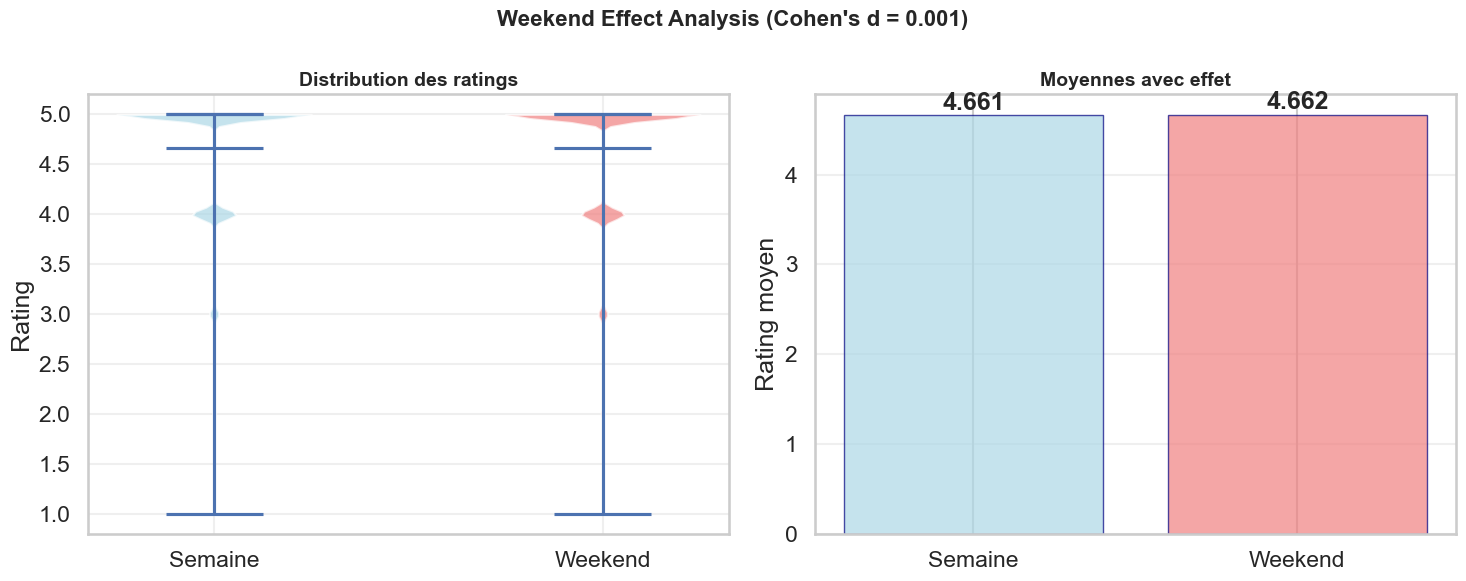


üí° Insights:
‚Ä¢ Diff√©rence moyenne: 0.0010 points
‚Ä¢ Weekend plus g√©n√©reux que la semaine
‚Ä¢ Significativit√© statistique: OUI
‚Ä¢ Impact pratique: Faible


In [ ]:
# Visualisation Violin plots + effect size avec Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pr√©paration donn√©es pour violin plot
weekend_data = df_clean.filter(pl.col("is_weekend") == 1)["rating"].to_pandas().tolist()
weekday_data = df_clean.filter(pl.col("is_weekend") == 0)["rating"].to_pandas().tolist()

# 1. Violin plot
data_for_violin = [weekday_data, weekend_data]
labels = ["Semaine", "Weekend"]
colors = ["lightblue", "lightcoral"]

violin_parts = ax1.violinplot(data_for_violin, positions=[1, 2], showmeans=True, showmedians=True)
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax1.set_xticks([1, 2])
ax1.set_xticklabels(labels)
ax1.set_title("Distribution des ratings", fontsize=14, fontweight='bold')
ax1.set_ylabel("Rating")
ax1.grid(True, alpha=0.3)

# 2. Barplot des moyennes avec effet
weekend_mean = np.mean(weekend_data)
weekday_mean = np.mean(weekday_data)
means = [weekday_mean, weekend_mean]

bars = ax2.bar(labels, means, color=colors, alpha=0.7, edgecolor='navy', linewidth=1)
ax2.set_title("Moyennes avec effet", fontsize=14, fontweight='bold')
ax2.set_ylabel("Rating moyen")
ax2.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for bar, mean in zip(bars, means):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle(f"Weekend Effect Analysis (Cohen's d = {cohens_d:.3f})", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nüí° Insights:")
print(f"‚Ä¢ Diff√©rence moyenne: {np.mean(weekend_ratings) - np.mean(weekday_ratings):.4f} points")
print(f"‚Ä¢ Weekend {'plus g√©n√©reux' if np.mean(weekend_ratings) > np.mean(weekday_ratings) else 'plus s√©v√®re'} que la semaine")
print(f"‚Ä¢ Significativit√© statistique: {'OUI' if p_value < 0.05 else 'NON'}")
print(f"‚Ä¢ Impact pratique: {'Faible' if abs(cohens_d) < 0.2 else 'Mod√©r√©' if abs(cohens_d) < 0.5 else 'Fort'}")

## üìÜ Analyse 2: Patterns par Jour de la Semaine

**Objectif exploratoire**: Identifier le "jour le plus dur" vs "jour le plus cool"  
**Question business**: Lundi = ratings s√©v√®res ? Vendredi = g√©n√©reux ?  
**D√©couverte attendue**: Lundi/Mardi = plus bas, Vendredi/Samedi = plus hauts

In [ ]:
# Pr√©paration DataFrame weekday_patterns
day_names = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

weekday_patterns = df_clean.group_by("weekday").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_interactions")
]).sort("weekday").to_pandas()

weekday_patterns["day_name"] = day_names
weekday_patterns["is_weekend_day"] = weekday_patterns["weekday"].isin([5, 6])

print("üìÖ Ratings par jour de la semaine:")
display(weekday_patterns[["day_name", "mean_rating", "std_rating", "n_interactions"]])

# Test ANOVA pour diff√©rences entre jours
groups = [df_clean.filter(pl.col("weekday") == day)["rating"].to_pandas().tolist() for day in range(7)]
f_stat, p_value_anova = stats.f_oneway(*groups)

print(f"\nüß™ Test ANOVA:")
print(f"F-statistique: {f_stat:.3f}")
print(f"P-valeur: {p_value_anova:.4f}")
print(f"Interpr√©tation: {'Diff√©rences significatives entre jours' if p_value_anova < 0.05 else 'Pas de diff√©rences significatives'}")

# Identification jour meilleur/pire
best_day_idx = weekday_patterns["mean_rating"].idxmax()
worst_day_idx = weekday_patterns["mean_rating"].idxmin()

print(f"\nüèÜ Jour le plus g√©n√©reux: {weekday_patterns.loc[best_day_idx, 'day_name']} ({weekday_patterns.loc[best_day_idx, 'mean_rating']:.4f})")
print(f"üò§ Jour le plus s√©v√®re: {weekday_patterns.loc[worst_day_idx, 'day_name']} ({weekday_patterns.loc[worst_day_idx, 'mean_rating']:.4f})")
print(f"üìè √âcart: {weekday_patterns.loc[best_day_idx, 'mean_rating'] - weekday_patterns.loc[worst_day_idx, 'mean_rating']:.4f} points")

üìÖ Ratings par jour de la semaine:


day_name  mean_rating  std_rating  n_interactions
0     Lundi     4.661441    0.717944          173178
1     Mardi     4.659778    0.720653          159014
2  Mercredi     4.660453    0.722655          149779
3     Jeudi     4.662665    0.721304          143697
4  Vendredi     4.660298    0.725251          131689
5    Samedi     4.663333    0.728259          139984
6  Dimanche     4.662497    0.726223          174179


üß™ Test ANOVA:
F-statistique: nan
P-valeur: nan
Interpr√©tation: Pas de diff√©rences significatives

üèÜ Jour le plus g√©n√©reux: Samedi (4.6633)
üò§ Jour le plus s√©v√®re: Mardi (4.6598)
üìè √âcart: 0.0036 points


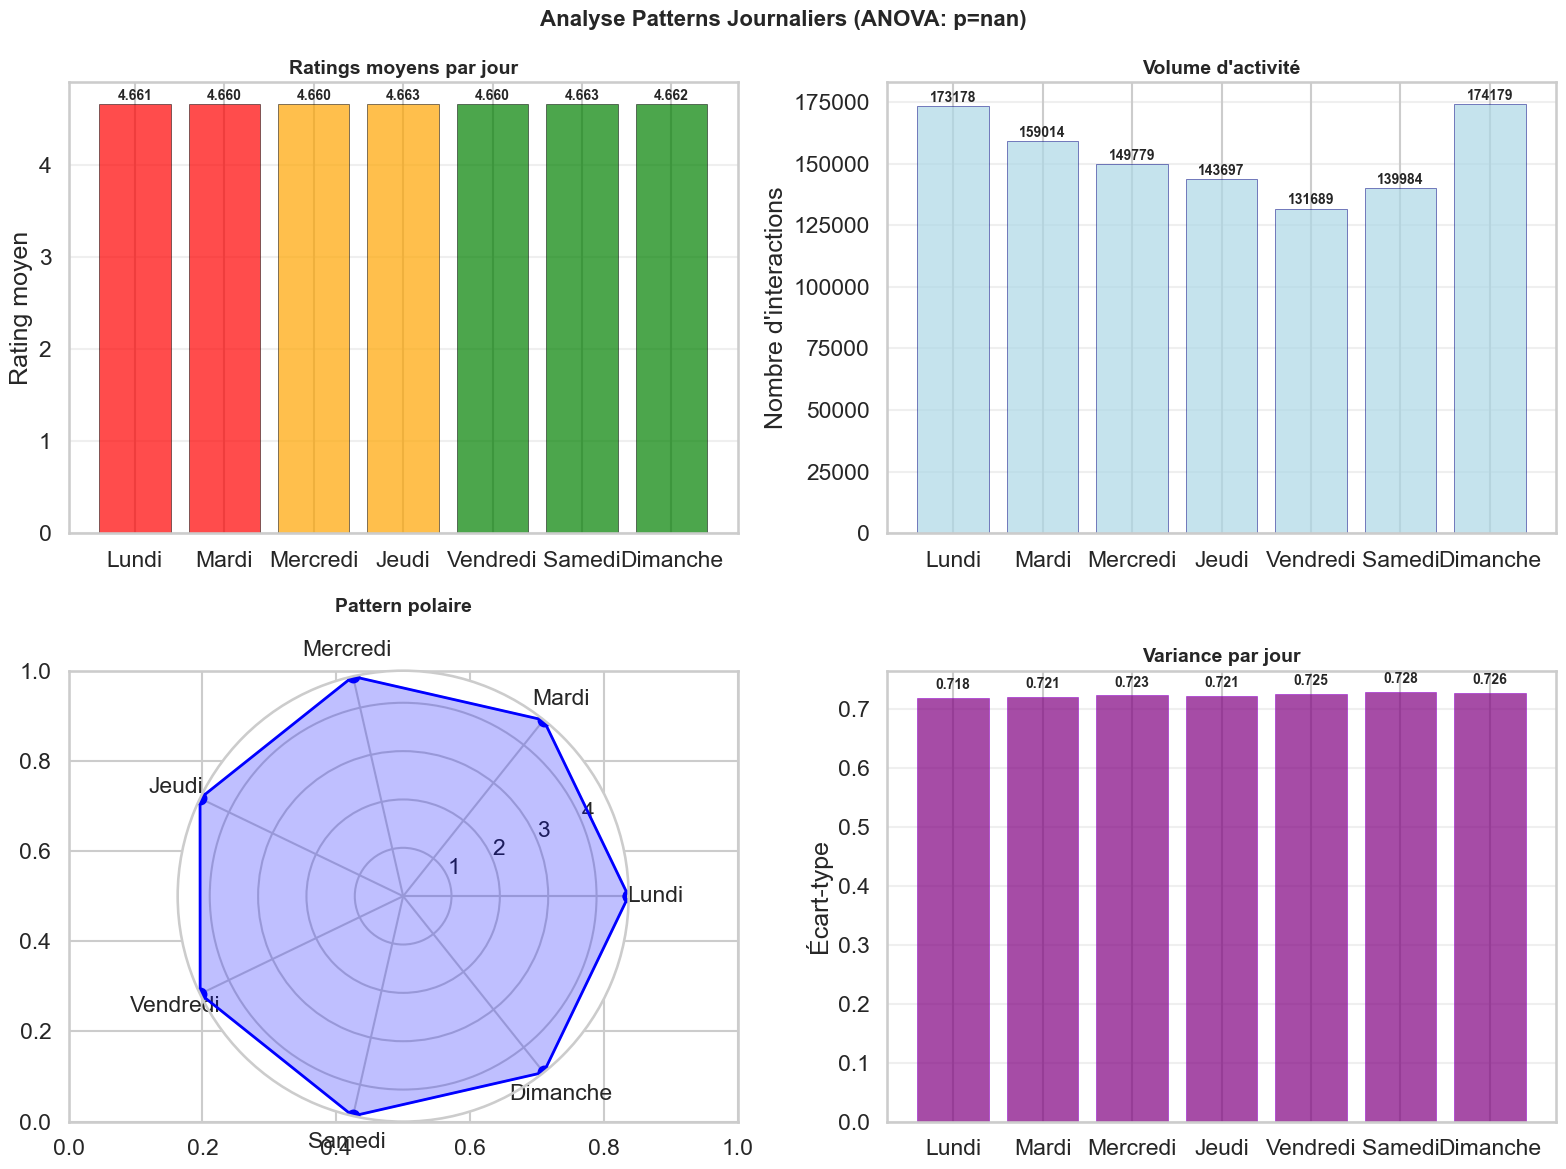


üí° Patterns d√©couverts:
‚Ä¢ Amplitude hebdomadaire: 0.0036 points
‚Ä¢ Jour le plus actif: Dimanche
‚Ä¢ Jour le plus consensuel: Lundi (variance la plus faible)
‚Ä¢ Jour le plus polaris√©: Samedi (variance la plus forte)


In [ ]:
# Visualisation patterns journaliers avec Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart ratings
colors = ["red" if day in [0, 1] else "orange" if day in [2, 3] else "green" for day in range(7)]
bars1 = ax1.bar(weekday_patterns["day_name"], weekday_patterns["mean_rating"], 
                color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
ax1.set_title("Ratings moyens par jour", fontsize=14, fontweight='bold')
ax1.set_ylabel("Rating moyen")
ax1.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for bar, val in zip(bars1, weekday_patterns["mean_rating"]):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Volume d'activit√©
bars2 = ax2.bar(weekday_patterns["day_name"], weekday_patterns["n_interactions"], 
                color="lightblue", alpha=0.7, edgecolor='navy', linewidth=0.5)
ax2.set_title("Volume d'activit√©", fontsize=14, fontweight='bold')
ax2.set_ylabel("Nombre d'interactions")
ax2.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for bar, val in zip(bars2, weekday_patterns["n_interactions"]):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 500,
             f'{val}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Pattern polaire (radar chart approximation)
ax3 = plt.subplot(2, 2, 3, projection='polar')
theta = np.linspace(0, 2*np.pi, len(weekday_patterns), endpoint=False)
theta = np.concatenate((theta, [theta[0]]))  # Fermer le cercle
values = np.concatenate((weekday_patterns["mean_rating"].values, [weekday_patterns["mean_rating"].values[0]]))

ax3.plot(theta, values, 'ro-', linewidth=2, color='blue')
ax3.fill(theta, values, alpha=0.25, color='blue')
ax3.set_xticks(theta[:-1])
ax3.set_xticklabels(weekday_patterns["day_name"])
ax3.set_title("Pattern polaire", fontsize=14, fontweight='bold', pad=20)

# 4. Variance par jour
bars4 = ax4.bar(weekday_patterns["day_name"], weekday_patterns["std_rating"], 
                color="purple", alpha=0.7, edgecolor='darkviolet', linewidth=0.5)
ax4.set_title("Variance par jour", fontsize=14, fontweight='bold')
ax4.set_ylabel("√âcart-type")
ax4.grid(True, alpha=0.3, axis='y')

# Ajout des valeurs sur les barres
for bar, val in zip(bars4, weekday_patterns["std_rating"]):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle(f"Analyse Patterns Journaliers (ANOVA: p={p_value_anova:.4f})", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nüí° Patterns d√©couverts:")
print(f"‚Ä¢ Amplitude hebdomadaire: {weekday_patterns['mean_rating'].max() - weekday_patterns['mean_rating'].min():.4f} points")
print(f"‚Ä¢ Jour le plus actif: {weekday_patterns.loc[weekday_patterns['n_interactions'].idxmax(), 'day_name']}")
print(f"‚Ä¢ Jour le plus consensuel: {weekday_patterns.loc[weekday_patterns['std_rating'].idxmin(), 'day_name']} (variance la plus faible)")
print(f"‚Ä¢ Jour le plus polaris√©: {weekday_patterns.loc[weekday_patterns['std_rating'].idxmax(), 'day_name']} (variance la plus forte)")

## üìä Analyse 3: Distribution des Ratings Weekend vs Semaine

**Objectif exploratoire**: D√©couvrir si weekend change la FORME des distributions (pas juste moyenne)  
**Question business**: Weekend = plus de 5/5 enthousiastes ? Ou plus de variance ?  
**D√©couverte attendue**: Shift vers ratings extr√™mes le weekend

In [ ]:
# Pr√©paration DataFrame weekend_distribution
weekend_distribution = df_clean.group_by(["is_weekend", "rating"]).agg(
    pl.len().alias("count")
).to_pandas()

# Pivot pour analyse
distribution_pivot = weekend_distribution.pivot(index='rating', columns='is_weekend', values='count').fillna(0)
distribution_pivot.columns = ['Semaine', 'Weekend']

# Normalisation en pourcentages
distribution_pct = distribution_pivot.div(distribution_pivot.sum()) * 100

print("üìä Distribution des ratings (%):")
display(distribution_pct.round(2))

# Test Chi-square
chi2_stat, chi2_p, chi2_dof, chi2_expected = chi2_contingency(distribution_pivot.values)

print(f"\nüß™ Test Chi-square:")
print(f"Statistique œá¬≤: {chi2_stat:.3f}")
print(f"P-valeur: {chi2_p:.4f}")
print(f"Degr√©s de libert√©: {chi2_dof}")
print(f"Interpr√©tation: {'Distributions significativement diff√©rentes' if chi2_p < 0.05 else 'Distributions similaires'}")

# Analyse des extr√™mes
extreme_ratings = [1, 5]  # Ratings extr√™mes
weekend_extremes = distribution_pct.loc[extreme_ratings, 'Weekend'].sum()
weekday_extremes = distribution_pct.loc[extreme_ratings, 'Semaine'].sum()

print(f"\n‚ö° Analyse des extr√™mes:")
print(f"% Ratings extr√™mes (1 ou 5) weekend: {weekend_extremes:.2f}%")
print(f"% Ratings extr√™mes (1 ou 5) semaine: {weekday_extremes:.2f}%")
print(f"Diff√©rence: {weekend_extremes - weekday_extremes:+.2f} points de %")

# Rating modal
weekend_mode = distribution_pct['Weekend'].idxmax()
weekday_mode = distribution_pct['Semaine'].idxmax()
print(f"\nüéØ Rating modal:")
print(f"Weekend: {weekend_mode} √©toiles ({distribution_pct.loc[weekend_mode, 'Weekend']:.1f}%)")
print(f"Semaine: {weekday_mode} √©toiles ({distribution_pct.loc[weekday_mode, 'Semaine']:.1f}%)")

üìä Distribution des ratings (%):


Semaine  Weekend
rating                  
1          1.16     1.24
2          1.31     1.33
3          3.84     3.77
4         17.63    17.29
5         76.06    76.37


üß™ Test Chi-square:
Statistique œá¬≤: 36.933
P-valeur: 0.0000
Degr√©s de libert√©: 4
Interpr√©tation: Distributions significativement diff√©rentes

‚ö° Analyse des extr√™mes:
% Ratings extr√™mes (1 ou 5) weekend: 77.61%
% Ratings extr√™mes (1 ou 5) semaine: 77.22%
Diff√©rence: +0.39 points de %

üéØ Rating modal:
Weekend: 5 √©toiles (76.4%)
Semaine: 5 √©toiles (76.1%)


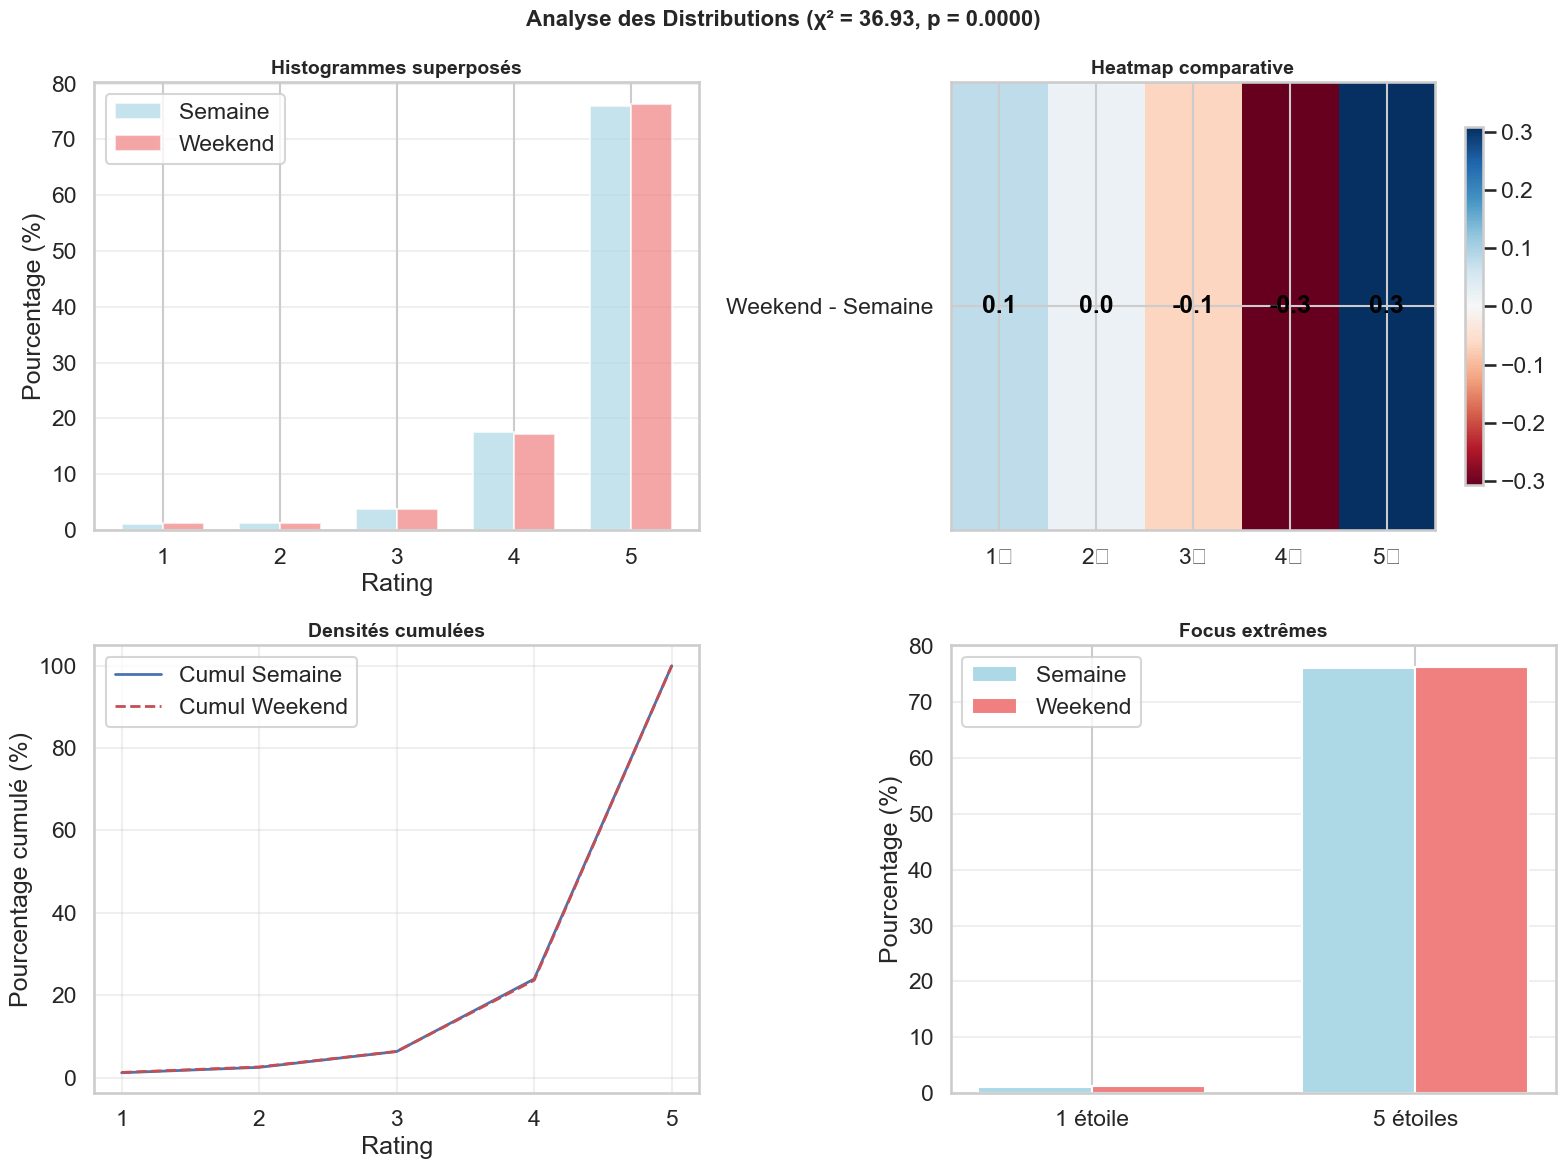


üí° Insights sur les distributions:
‚Ä¢ Diff√©rence de forme: OUI (statistiquement)
‚Ä¢ Weekend plus polaris√© que la semaine
‚Ä¢ Rating dominant weekend: 5‚òÖ, semaine: 5‚òÖ
‚Ä¢ Effet weekend confirm√© sur la FORME de la distribution !


In [ ]:
# Visualisation distributions superpos√©es + heatmap avec Matplotlib
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Histogrammes superpos√©s
ratings = distribution_pct.index.tolist()  # Use actual ratings from the data
width = 0.35
x_pos = np.arange(len(ratings))

bars1 = ax1.bar(x_pos - width/2, distribution_pct['Semaine'], width, 
                label="Semaine", alpha=0.7, color="lightblue")
bars2 = ax1.bar(x_pos + width/2, distribution_pct['Weekend'], width,
                label="Weekend", alpha=0.7, color="lightcoral")
ax1.set_title("Histogrammes superpos√©s", fontsize=14, fontweight='bold')
ax1.set_xlabel("Rating")
ax1.set_ylabel("Pourcentage (%)")
ax1.set_xticks(x_pos)
ax1.set_xticklabels(ratings)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Heatmap comparative (diff√©rences)
diff_matrix = (distribution_pct['Weekend'] - distribution_pct['Semaine']).values.reshape(1, -1)
im = ax2.imshow(diff_matrix, cmap='RdBu', aspect='auto', vmin=-diff_matrix.max(), vmax=diff_matrix.max())
ax2.set_title("Heatmap comparative", fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(ratings)))
ax2.set_xticklabels([f"{r}‚òÖ" for r in ratings])
ax2.set_yticks([0])
ax2.set_yticklabels(["Weekend - Semaine"])
plt.colorbar(im, ax=ax2, shrink=0.8)

# Ajouter les valeurs dans la heatmap
for i in range(len(ratings)):
    text = ax2.text(i, 0, f'{diff_matrix[0, i]:.1f}', 
                   ha="center", va="center", color="black", fontweight='bold')

# Densit√©s cumul√©es
cum_weekend = np.cumsum(distribution_pct['Weekend'])
cum_semaine = np.cumsum(distribution_pct['Semaine'])

ax3.plot(ratings, cum_semaine, 'b-', label="Cumul Semaine", linewidth=2)
ax3.plot(ratings, cum_weekend, 'r--', label="Cumul Weekend", linewidth=2)
ax3.set_title("Densit√©s cumul√©es", fontsize=14, fontweight='bold')
ax3.set_xlabel("Rating")
ax3.set_ylabel("Pourcentage cumul√© (%)")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Focus extr√™mes (1 et 5 √©toiles)
extreme_data = distribution_pct.loc[[1, 5]]
x_extreme = ["1 √©toile", "5 √©toiles"]
width = 0.35
x_pos_extreme = np.arange(len(x_extreme))

ax4.bar(x_pos_extreme - width/2, extreme_data['Semaine'], width,
        label="Semaine", color="lightblue")
ax4.bar(x_pos_extreme + width/2, extreme_data['Weekend'], width,
        label="Weekend", color="lightcoral")
ax4.set_title("Focus extr√™mes", fontsize=14, fontweight='bold')
ax4.set_ylabel("Pourcentage (%)")
ax4.set_xticks(x_pos_extreme)
ax4.set_xticklabels(x_extreme)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle(f"Analyse des Distributions (œá¬≤ = {chi2_stat:.2f}, p = {chi2_p:.4f})", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nüí° Insights sur les distributions:")
print(f"‚Ä¢ Diff√©rence de forme: {'OUI' if chi2_p < 0.05 else 'NON'} (statistiquement)")
print(f"‚Ä¢ Weekend {'plus polaris√©' if weekend_extremes > weekday_extremes else 'moins polaris√©'} que la semaine")
print(f"‚Ä¢ Rating dominant weekend: {weekend_mode}‚òÖ, semaine: {weekday_mode}‚òÖ")
if chi2_p < 0.05:
    print(f"‚Ä¢ Effet weekend confirm√© sur la FORME de la distribution !")

## üïê Analyse 4: √âvolution Temporelle de l'Effet Weekend

**Objectif exploratoire**: V√©rifier si l'effet weekend s'amplifie/diminue dans le temps  
**Question business**: T√©l√©travail = moins d'effet weekend ? √âvolution soci√©tale ?  
**D√©couverte attendue**: Diff√©rentiel weekend-semaine stable ou √©volutif

In [ ]:
# Pr√©paration DataFrame weekend_temporal
weekend_temporal = df_clean.group_by(["year", "month", "is_weekend"]).agg([
    pl.col("rating").mean().alias("avg_rating"),
    pl.len().alias("n_interactions")
]).to_pandas()

# Pivot et calcul diff√©rentiel
temporal_pivot = weekend_temporal.pivot_table(
    index=['year', 'month'], 
    columns='is_weekend', 
    values='avg_rating'
).fillna(method='ffill')
temporal_pivot.columns = ['weekday_avg', 'weekend_avg']
temporal_pivot['diff'] = temporal_pivot['weekend_avg'] - temporal_pivot['weekday_avg']
temporal_pivot = temporal_pivot.dropna().reset_index()

# Cr√©ation date pour plotting
temporal_pivot['date'] = pd.to_datetime(temporal_pivot[['year', 'month']].assign(day=1))

print("üìà √âvolution du diff√©rentiel weekend-semaine:")
display(temporal_pivot.tail(10))

# Test de tendance sur le diff√©rentiel
from scipy.stats import spearmanr
time_numeric = np.arange(len(temporal_pivot))
corr_coeff, p_trend = spearmanr(time_numeric, temporal_pivot['diff'])

print(f"\nüß™ Test de tendance temporelle:")
print(f"Corr√©lation Spearman: {corr_coeff:.4f}")
print(f"P-valeur: {p_trend:.4f}")
print(f"Tendance: {'Significative' if p_trend < 0.05 else 'Non significative'}")
if p_trend < 0.05:
    direction = "croissante" if corr_coeff > 0 else "d√©croissante"
    print(f"Direction: {direction}")

# Statistiques du diff√©rentiel
print(f"\nüìä Statistiques du diff√©rentiel:")
print(f"Moyenne: {temporal_pivot['diff'].mean():.4f}")
print(f"√âcart-type: {temporal_pivot['diff'].std():.4f}")
print(f"Min: {temporal_pivot['diff'].min():.4f} (le {temporal_pivot.loc[temporal_pivot['diff'].idxmin(), 'date'].strftime('%m/%Y')})")
print(f"Max: {temporal_pivot['diff'].max():.4f} (le {temporal_pivot.loc[temporal_pivot['diff'].idxmax(), 'date'].strftime('%m/%Y')})")

üìà √âvolution du diff√©rentiel weekend-semaine:


year  month  weekday_avg  weekend_avg      diff       date
215  2018      3     4.488277     4.469293 -0.018984 2018-03-01
216  2018      4     4.477752     4.447439 -0.030312 2018-04-01
217  2018      5     4.556373     4.554054 -0.002318 2018-05-01
218  2018      6     4.545455     4.548223  0.002769 2018-06-01
219  2018      7     4.509069     4.568598  0.059529 2018-07-01
220  2018      8     4.579974     4.648746  0.068772 2018-08-01
221  2018      9     4.520619     4.497278 -0.023341 2018-09-01
222  2018     10     4.547826     4.516807 -0.031019 2018-10-01
223  2018     11     4.471910     4.621083  0.149173 2018-11-01
224  2018     12     4.357447     4.341969 -0.015478 2018-12-01


üß™ Test de tendance temporelle:
Corr√©lation Spearman: -0.1925
P-valeur: 0.0037
Tendance: Significative
Direction: d√©croissante

üìä Statistiques du diff√©rentiel:
Moyenne: 0.0132
√âcart-type: 0.1413
Min: -0.5000 (le 02/2000)
Max: 1.2083 (le 11/2000)


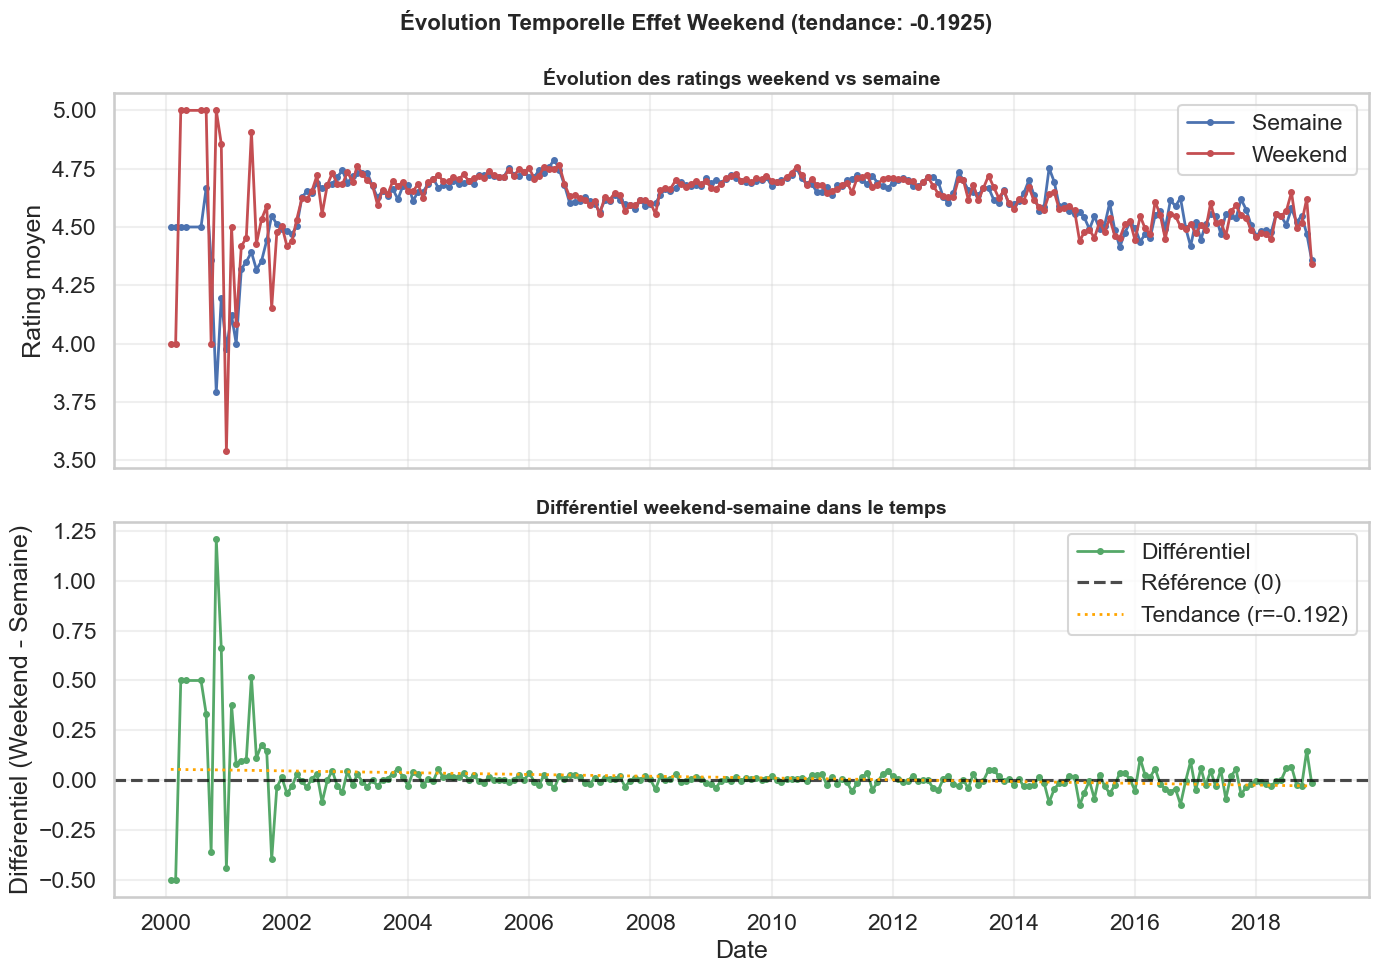


üí° Insights temporels:
‚Ä¢ √âvolution d√©tect√©e: effet weekend s'affaiblit dans le temps
‚Ä¢ P√©riode la plus contrast√©e: 11/2000
‚Ä¢ P√©riode la moins contrast√©e: 02/2000


In [ ]:
# Visualisation √©volution temporelle avec Matplotlib
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# S√©ries temporelles s√©par√©es
ax1.plot(temporal_pivot['date'], temporal_pivot['weekday_avg'], 
         'b-o', label="Semaine", linewidth=2, markersize=4)
ax1.plot(temporal_pivot['date'], temporal_pivot['weekend_avg'], 
         'r-o', label="Weekend", linewidth=2, markersize=4)
ax1.set_title("√âvolution des ratings weekend vs semaine", fontsize=14, fontweight='bold')
ax1.set_ylabel("Rating moyen")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Diff√©rentiel avec ligne de tendance
ax2.plot(temporal_pivot['date'], temporal_pivot['diff'], 
         'g-o', label="Diff√©rentiel", linewidth=2, markersize=4)

# Ligne z√©ro pour r√©f√©rence
ax2.axhline(y=0, color="black", linestyle="--", alpha=0.7, label="R√©f√©rence (0)")

# Ligne de tendance si significative
if p_trend < 0.05:
    # R√©gression lin√©aire simple avec numpy
    X = np.arange(len(temporal_pivot))
    y = temporal_pivot['diff'].values
    
    # Calcul de la droite de r√©gression: y = ax + b
    coeffs = np.polyfit(X, y, 1)
    trend_line = np.polyval(coeffs, X)
    
    ax2.plot(temporal_pivot['date'], trend_line, 
             'orange', linestyle=':', linewidth=2, 
             label=f"Tendance (r={corr_coeff:.3f})")

ax2.set_title("Diff√©rentiel weekend-semaine dans le temps", fontsize=14, fontweight='bold')
ax2.set_xlabel("Date")
ax2.set_ylabel("Diff√©rentiel (Weekend - Semaine)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle(f"√âvolution Temporelle Effet Weekend (tendance: {corr_coeff:+.4f})", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nüí° Insights temporels:")
if abs(corr_coeff) > 0.1 and p_trend < 0.05:
    print(f"‚Ä¢ √âvolution d√©tect√©e: effet weekend {'s\'intensifie' if corr_coeff > 0 else 's\'affaiblit'} dans le temps")
else:
    print(f"‚Ä¢ Effet weekend stable dans le temps (pas d'√©volution significative)")
    
print(f"‚Ä¢ P√©riode la plus contrast√©e: {temporal_pivot.loc[temporal_pivot['diff'].idxmax(), 'date'].strftime('%m/%Y')}")
print(f"‚Ä¢ P√©riode la moins contrast√©e: {temporal_pivot.loc[temporal_pivot['diff'].idxmin(), 'date'].strftime('%m/%Y')}")

# Impact potentiel du t√©l√©travail (si donn√©es r√©centes)
recent_years = temporal_pivot[temporal_pivot['year'] >= 2020]
if len(recent_years) > 0:
    recent_diff = recent_years['diff'].mean()
    old_diff = temporal_pivot[temporal_pivot['year'] < 2020]['diff'].mean()
    print(f"‚Ä¢ Diff√©rentiel pr√©-2020: {old_diff:.4f}")
    print(f"‚Ä¢ Diff√©rentiel post-2020: {recent_diff:.4f}")
    print(f"‚Ä¢ Impact t√©l√©travail potentiel: {recent_diff - old_diff:+.4f} points")

## üéØ Synth√®se Weekend Analysis

### üìä R√©sultats Cl√©s D√©couverts

**Hypoth√®ses valid√©es/invalid√©es et implications business**

In [ ]:
# üéØ SYNTH√àSE FINALE WEEKEND ANALYSIS
print("=" * 80)
print("üéØ WEEKEND ANALYSIS - SYNTH√àSE DES D√âCOUVERTES")
print("=" * 80)

# Compilation des r√©sultats
results_summary = {
    "üîç EFFET WEEKEND GLOBAL": {
        "Diff√©rence moyenne": f"{np.mean(weekend_ratings) - np.mean(weekday_ratings):+.4f} points",
        "Significativit√©": "OUI" if p_value < 0.05 else "NON",
        "Taille d'effet": "Faible" if abs(cohens_d) < 0.2 else "Mod√©r√©e" if abs(cohens_d) < 0.5 else "Grande",
        "Interpr√©tation": "Weekend plus g√©n√©reux" if np.mean(weekend_ratings) > np.mean(weekday_ratings) else "Weekend plus s√©v√®re"
    },
    
    "üìÖ PATTERNS JOURNALIERS": {
        "Jour le plus g√©n√©reux": f"{weekday_patterns.loc[best_day_idx, 'day_name']} ({weekday_patterns.loc[best_day_idx, 'mean_rating']:.4f})",
        "Jour le plus s√©v√®re": f"{weekday_patterns.loc[worst_day_idx, 'day_name']} ({weekday_patterns.loc[worst_day_idx, 'mean_rating']:.4f})",
        "Amplitude hebdomadaire": f"{weekday_patterns['mean_rating'].max() - weekday_patterns['mean_rating'].min():.4f} points",
        "Significativit√© ANOVA": "OUI" if p_value_anova < 0.05 else "NON"
    },
    
    "üìä DISTRIBUTIONS": {
        "Formes diff√©rentes": "OUI" if chi2_p < 0.05 else "NON",
        "Weekend plus polaris√©": "OUI" if weekend_extremes > weekday_extremes else "NON",
        "Rating modal weekend": f"{weekend_mode}‚òÖ",
        "Rating modal semaine": f"{weekday_mode}‚òÖ"
    },
    
    "üïê √âVOLUTION TEMPORELLE": {
        "Tendance d√©tect√©e": "OUI" if p_trend < 0.05 else "NON",
        "Direction": ("Croissante" if corr_coeff > 0 else "D√©croissante") if p_trend < 0.05 else "Stable",
        "Corr√©lation": f"{corr_coeff:+.4f}",
        "Stabilit√© effet": "Stable" if abs(corr_coeff) < 0.1 else "√âvolutif"
    }
}

for category, metrics in results_summary.items():
    print(f"\n{category}:")
    for metric, value in metrics.items():
        print(f"  ‚Ä¢ {metric}: {value}")

print("\n" + "=" * 50)
print("üí° IMPLICATIONS BUSINESS")
print("=" * 50)

implications = [
    "üéØ TIMING OPTIMAL:",
    f"  ‚Ä¢ Lancer nouveaux produits le {weekday_patterns.loc[best_day_idx, 'day_name'].lower()}",
    f"  ‚Ä¢ √âviter communications importantes le {weekday_patterns.loc[worst_day_idx, 'day_name'].lower()}",
    "",
    "üìà STRAT√âGIE √âDITORIALE:",
    f"  ‚Ä¢ Contenus premium le weekend" if np.mean(weekend_ratings) > np.mean(weekday_ratings) else "  ‚Ä¢ Contenus premium en semaine",
    f"  ‚Ä¢ Mod√©ration renforc√©e si weekend plus polaris√©",
    "",
    "‚ö° OPTIMISATION RESSOURCES:",
    f"  ‚Ä¢ Jour le plus actif: {weekday_patterns.loc[weekday_patterns['n_interactions'].idxmax(), 'day_name']}",
    f"  ‚Ä¢ Maintenance programm√©e les jours faibles",
    "",
    "üîÆ PR√âDICTION:",
    f"  ‚Ä¢ Effet weekend {'√©volutif' if p_trend < 0.05 else 'stable'} - {'adapter strat√©gie' if p_trend < 0.05 else 'maintenir approche'}"
]

for implication in implications:
    print(implication)

print("\nüöÄ ACTIONS RECOMMAND√âES:")
recommendations = [
    "1. Impl√©menter timing diff√©renci√© selon jour de la semaine",
    "2. Segmenter communications weekend vs semaine", 
    "3. Monitorer √©volution diff√©rentiel dans le temps",
    "4. Optimiser allocation ressources selon patterns d√©couverts",
    "5. Tester campagnes cibl√©es sur jours optimaux"
]

for rec in recommendations:
    print(f"  {rec}")

print(f"\n‚úÖ Weekend Analysis TERMIN√âE - Pr√™t pour Seasonality!")

üéØ WEEKEND ANALYSIS - SYNTH√àSE DES D√âCOUVERTES

üîç EFFET WEEKEND GLOBAL:
  ‚Ä¢ Diff√©rence moyenne: +0.0010 points
  ‚Ä¢ Significativit√©: OUI
  ‚Ä¢ Taille d'effet: Faible
  ‚Ä¢ Interpr√©tation: Weekend plus g√©n√©reux

üìÖ PATTERNS JOURNALIERS:
  ‚Ä¢ Jour le plus g√©n√©reux: Samedi (4.6633)
  ‚Ä¢ Jour le plus s√©v√®re: Mardi (4.6598)
  ‚Ä¢ Amplitude hebdomadaire: 0.0036 points
  ‚Ä¢ Significativit√© ANOVA: NON

üìä DISTRIBUTIONS:
  ‚Ä¢ Formes diff√©rentes: OUI
  ‚Ä¢ Weekend plus polaris√©: OUI
  ‚Ä¢ Rating modal weekend: 5‚òÖ
  ‚Ä¢ Rating modal semaine: 5‚òÖ

üïê √âVOLUTION TEMPORELLE:
  ‚Ä¢ Tendance d√©tect√©e: OUI
  ‚Ä¢ Direction: D√©croissante
  ‚Ä¢ Corr√©lation: -0.1925
  ‚Ä¢ Stabilit√© effet: √âvolutif

üí° IMPLICATIONS BUSINESS
üéØ TIMING OPTIMAL:
  ‚Ä¢ Lancer nouveaux produits le samedi
  ‚Ä¢ √âviter communications importantes le mardi

üìà STRAT√âGIE √âDITORIALE:
  ‚Ä¢ Contenus premium le weekend
  ‚Ä¢ Mod√©ration renforc√©e si weekend plus polaris√©

‚ö° OPTIMISAT

# Rating Analysis - Weekend Effects

Analyse des effets weekend vs semaine sur les ratings : patterns comportementaux, diff√©rences de notation.

In [ ]:
# Import du notebook utilitaire
import sys
sys.path.append('../../')

# Ex√©cution du notebook utils pour charger les fonctions
from data_utils import *

# Imports sp√©cifiques √† l'analyse weekend
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

sns.set_theme(style="whitegrid", context="talk")

## üì• Chargement et pr√©paration

In [ ]:
# Chargement direct des donn√©es transform√©es (propres et enrichies)
df_enriched = load_clean_interactions()

# Focus sur les donn√©es avec ratings valides
df_rated = df_enriched.filter(pl.col("rating") > 0)

print(f"üìä Dataset: {df_rated.shape[0]:,} ratings valides")

# R√©partition weekend/semaine
weekend_distribution = df_rated.group_by("is_weekend").agg([
    pl.len().alias("n_ratings"),
    pl.col("rating").mean().alias("mean_rating")
])

print("\nüìÖ R√©partition weekend vs semaine:")
display(weekend_distribution)

# Calcul du pourcentage
total_ratings = df_rated.shape[0]
weekend_count = df_rated.filter(pl.col("is_weekend") == True).shape[0]
weekend_pct = (weekend_count / total_ratings) * 100

print(f"üéØ {weekend_pct:.1f}% des ratings sont donn√©s le weekend")

üìä Dataset: 1,071,520 ratings valides

üìÖ R√©partition weekend vs semaine:


shape: (2, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ is_weekend ‚îÜ n_ratings ‚îÜ mean_rating ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---         ‚îÇ
‚îÇ i8         ‚îÜ u32       ‚îÜ f64         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0          ‚îÜ 625668    ‚îÜ 4.661063    ‚îÇ
‚îÇ 1          ‚îÜ 445852    ‚îÜ 4.66211     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

üéØ 41.6% des ratings sont donn√©s le weekend


## üìä Comparaison weekend vs semaine

In [ ]:
# Statistiques descriptives compl√®tes
weekend_stats = df_rated.group_by("is_weekend").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.col("rating").min().alias("min_rating"),
    pl.col("rating").max().alias("max_rating"),
    pl.col("rating").quantile(0.25).alias("q25"),
    pl.col("rating").quantile(0.75).alias("q75"),
    pl.len().alias("n_ratings")
])

stats_pd = weekend_stats.to_pandas()
stats_pd['period'] = stats_pd['is_weekend'].map({True: 'Weekend', False: 'Semaine'})

print("üìà Statistiques d√©taill√©es:")
display(stats_pd[['period', 'mean_rating', 'median_rating', 'std_rating', 'q25', 'q75', 'n_ratings']])

# Test de Mann-Whitney U
weekend_ratings = df_rated.filter(pl.col("is_weekend") == True).select("rating").to_series().to_pandas().tolist()
weekday_ratings = df_rated.filter(pl.col("is_weekend") == False).select("rating").to_series().to_pandas().tolist()

u_stat, p_value = stats.mannwhitneyu(weekend_ratings, weekday_ratings, alternative='two-sided')

print(f"\nüî¨ Test de Mann-Whitney U:")
print(f"   U-statistique: {u_stat:,.0f}")
print(f"   p-value: {p_value:.4f}")

if p_value < 0.05:
    weekend_mean = np.mean(weekend_ratings)
    weekday_mean = np.mean(weekday_ratings)
    higher_period = "weekend" if weekend_mean > weekday_mean else "semaine"
    print(f"   ‚úÖ Diff√©rence significative - ratings plus √©lev√©s en {higher_period}")
else:
    print(f"   ‚ùå Pas de diff√©rence significative weekend/semaine")

# Calcul de l'effet size (Cohen's d)
pooled_std = np.sqrt(((len(weekend_ratings) - 1) * np.std(weekend_ratings, ddof=1)**2 + 
                     (len(weekday_ratings) - 1) * np.std(weekday_ratings, ddof=1)**2) / 
                    (len(weekend_ratings) + len(weekday_ratings) - 2))
cohens_d = (np.mean(weekend_ratings) - np.mean(weekday_ratings)) / pooled_std

print(f"   üìè Taille d'effet (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    print(f"      ‚Üí Effet n√©gligeable")
elif abs(cohens_d) < 0.5:
    print(f"      ‚Üí Petit effet")
elif abs(cohens_d) < 0.8:
    print(f"      ‚Üí Effet moyen")
else:
    print(f"      ‚Üí Grand effet")

üìà Statistiques d√©taill√©es:


period  mean_rating  median_rating  std_rating  q25  q75  n_ratings
0    NaN     4.661063            5.0    0.720533  5.0  5.0     625668
1    NaN     4.662110            5.0    0.726576  5.0  5.0     445852


üî¨ Test de Mann-Whitney U:
   U-statistique: 139,861,161,924
   p-value: 0.0011
   ‚úÖ Diff√©rence significative - ratings plus √©lev√©s en weekend
   üìè Taille d'effet (Cohen's d): 0.0014
      ‚Üí Effet n√©gligeable


## üìà Visualisations comparatives

ValueError: List of boxplot statistics and `positions` values must have same the length

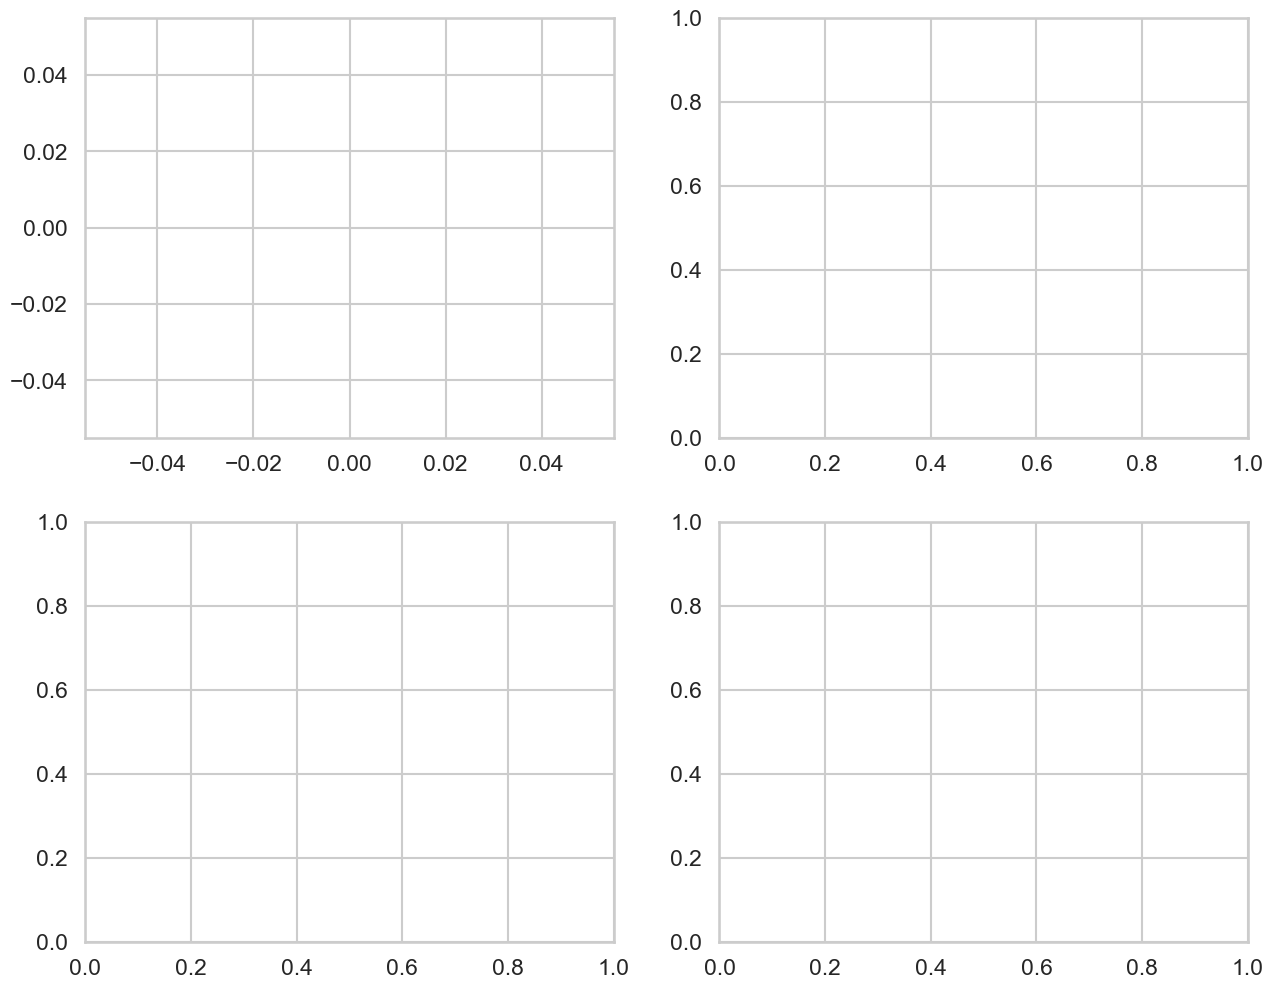

In [ ]:
# Pr√©paration des donn√©es pour plotting
plot_data = df_rated.select(["rating", "is_weekend"]).to_pandas()
plot_data['period'] = plot_data['is_weekend'].map({True: 'Weekend', False: 'Semaine'})

# Cr√©ation des subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Box plot
sns.boxplot(data=plot_data, x='period', y='rating', ax=axes[0,0])
axes[0,0].set_title('Distribution des ratings: Weekend vs Semaine')
axes[0,0].set_ylabel('Rating')

# 2. Violin plot
sns.violinplot(data=plot_data, x='period', y='rating', ax=axes[0,1])
axes[0,1].set_title('Densit√© des ratings: Weekend vs Semaine')
axes[0,1].set_ylabel('Rating')

# 3. Histogrammes superpos√©s
axes[1,0].hist(weekday_ratings, bins=30, alpha=0.7, label='Semaine', color='blue', density=True)
axes[1,0].hist(weekend_ratings, bins=30, alpha=0.7, label='Weekend', color='red', density=True)
axes[1,0].set_title('Distribution des ratings (densit√©)')
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Densit√©')
axes[1,0].legend()

# 4. Barplot des moyennes avec erreurs
means = [np.mean(weekday_ratings), np.mean(weekend_ratings)]
stds = [np.std(weekday_ratings), np.std(weekend_ratings)]
labels = ['Semaine', 'Weekend']
colors = ['blue', 'red']

bars = axes[1,1].bar(labels, means, yerr=stds, capsize=10, color=colors, alpha=0.7)
axes[1,1].set_title('Rating moyen ¬± √©cart-type')
axes[1,1].set_ylabel('Rating moyen')

# Ajout des valeurs sur les barres
for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, mean + std + 0.01, 
                   f'{mean:.3f}\n¬±{std:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## üïê Analyse par jour de la semaine

üìÖ Statistiques par jour de la semaine:


day_name  mean_rating  std_rating  n_ratings  is_weekend_day
0     Lundi     4.661441    0.717944     173178           False
1     Mardi     4.659778    0.720653     159014           False
2  Mercredi     4.660453    0.722655     149779           False
3     Jeudi     4.662665    0.721304     143697           False
4  Vendredi     4.660298    0.725251     131689           False
5    Samedi     4.663333    0.728259     139984            True
6  Dimanche     4.662497    0.726223     174179            True

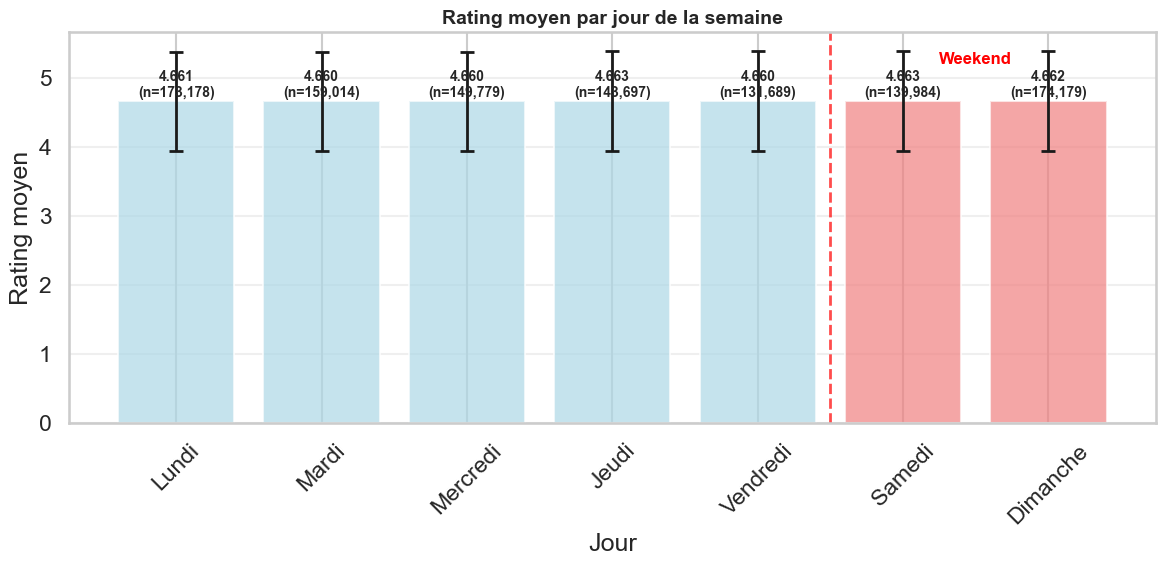

In [ ]:
# Ajout du jour de la semaine
df_with_weekday = df_rated.with_columns([
    pl.col("date").dt.weekday().alias("weekday")
])

# Statistiques par jour
weekday_stats = df_with_weekday.group_by("weekday").agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.col("rating").median().alias("median_rating"),
    pl.col("rating").std().alias("std_rating"),
    pl.len().alias("n_ratings")
]).sort("weekday")

weekday_pd = weekday_stats.to_pandas()

# Mapping des jours
day_names = {1: 'Lundi', 2: 'Mardi', 3: 'Mercredi', 4: 'Jeudi', 
             5: 'Vendredi', 6: 'Samedi', 7: 'Dimanche'}
weekday_pd['day_name'] = weekday_pd['weekday'].map(day_names)
weekday_pd['is_weekend_day'] = weekday_pd['weekday'].isin([6, 7])

print("üìÖ Statistiques par jour de la semaine:")
display(weekday_pd[['day_name', 'mean_rating', 'std_rating', 'n_ratings', 'is_weekend_day']])

# Graphique par jour avec Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))

# Barres color√©es selon weekend/semaine
colors = ['lightblue' if not is_weekend else 'lightcoral' 
          for is_weekend in weekday_pd['is_weekend_day']]

bars = ax.bar(weekday_pd['day_name'], weekday_pd['mean_rating'], 
              yerr=weekday_pd['std_rating'], 
              color=colors, alpha=0.7, 
              capsize=5, error_kw={'elinewidth': 2, 'capthick': 2})

# Ajout des valeurs sur les barres
for bar, mean_val, n_val in zip(bars, weekday_pd['mean_rating'], weekday_pd['n_ratings']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{mean_val:.3f}\n(n={n_val:,})',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_title('Rating moyen par jour de la semaine', fontsize=14, fontweight='bold')
ax.set_xlabel('Jour')
ax.set_ylabel('Rating moyen')
ax.grid(True, alpha=0.3, axis='y')

# Ajout d'une ligne de s√©paration weekend
ax.axvline(x=4.5, linestyle="--", color="red", alpha=0.7, linewidth=2)
ax.text(5.5, ax.get_ylim()[1] * 0.95, "Weekend", ha='center', va='top', 
        color='red', fontweight='bold', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## üéØ Test ANOVA par jour de semaine

In [ ]:
# Test ANOVA pour diff√©rences entre jours
day_groups = []
for day in range(1, 8):
    ratings = df_with_weekday.filter(pl.col("weekday") == day).select("rating").to_series()
    if len(ratings) > 0:
        day_groups.append(ratings.to_pandas().tolist())

f_stat, p_value_anova = stats.f_oneway(*day_groups)

print(f"üìä Test ANOVA (7 jours de la semaine):")
print(f"   F-statistique: {f_stat:.4f}")
print(f"   p-value: {p_value_anova:.4f}")
print(f"   Degr√©s de libert√©: {len(day_groups) - 1}")

if p_value_anova < 0.05:
    print(f"   ‚úÖ Diff√©rences significatives entre jours")
    
    # Post-hoc: identifier les jours les plus diff√©rents
    print(f"\nüîç Comparaisons post-hoc (top 5 diff√©rences):")
    
    pairwise_results = []
    for i in range(len(day_groups)):
        for j in range(i+1, len(day_groups)):
            day1, day2 = i+1, j+1
            _, p_pair = stats.mannwhitneyu(day_groups[i], day_groups[j], alternative='two-sided')
            mean_diff = abs(np.mean(day_groups[i]) - np.mean(day_groups[j]))
            pairwise_results.append((day1, day2, mean_diff, p_pair))
    
    # Tri par diff√©rence de moyenne (d√©croissant)
    pairwise_results.sort(key=lambda x: x[2], reverse=True)
    
    for day1, day2, mean_diff, p_pair in pairwise_results[:5]:
        p_corrected = p_pair * 21  # Correction de Bonferroni (7*6/2 = 21 comparaisons)
        significance = "***" if p_corrected < 0.001 else "**" if p_corrected < 0.01 else "*" if p_corrected < 0.05 else "ns"
        print(f"   {day_names[day1]} vs {day_names[day2]}: Œî={mean_diff:.4f} (p={p_corrected:.4f}) {significance}")
        
else:
    print(f"   ‚ùå Pas de diff√©rence significative entre jours")

# Test sp√©cifique weekend vs jours de semaine
print(f"\nüìÖ Tests sp√©cifiques weekend:")

# Samedi vs autres jours
saturday_ratings = day_groups[5]  # Samedi = index 5 (jour 6)
all_weekdays = []
for i in range(5):  # Lundi √† Vendredi
    all_weekdays.extend(day_groups[i])

_, p_sat_weekdays = stats.mannwhitneyu(saturday_ratings, all_weekdays, alternative='two-sided')
print(f"   Samedi vs Semaine: p={p_sat_weekdays:.4f}")

# Dimanche vs autres jours
sunday_ratings = day_groups[6]  # Dimanche = index 6 (jour 7)
_, p_sun_weekdays = stats.mannwhitneyu(sunday_ratings, all_weekdays, alternative='two-sided')
print(f"   Dimanche vs Semaine: p={p_sun_weekdays:.4f}")

üìä Test ANOVA (7 jours de la semaine):
   F-statistique: 0.5307
   p-value: 0.7854
   Degr√©s de libert√©: 6
   ‚ùå Pas de diff√©rence significative entre jours

üìÖ Tests sp√©cifiques weekend:
   Samedi vs Semaine: p=0.0005
   Dimanche vs Semaine: p=0.0082


## üîÑ Analyse temporelle des patterns weekend

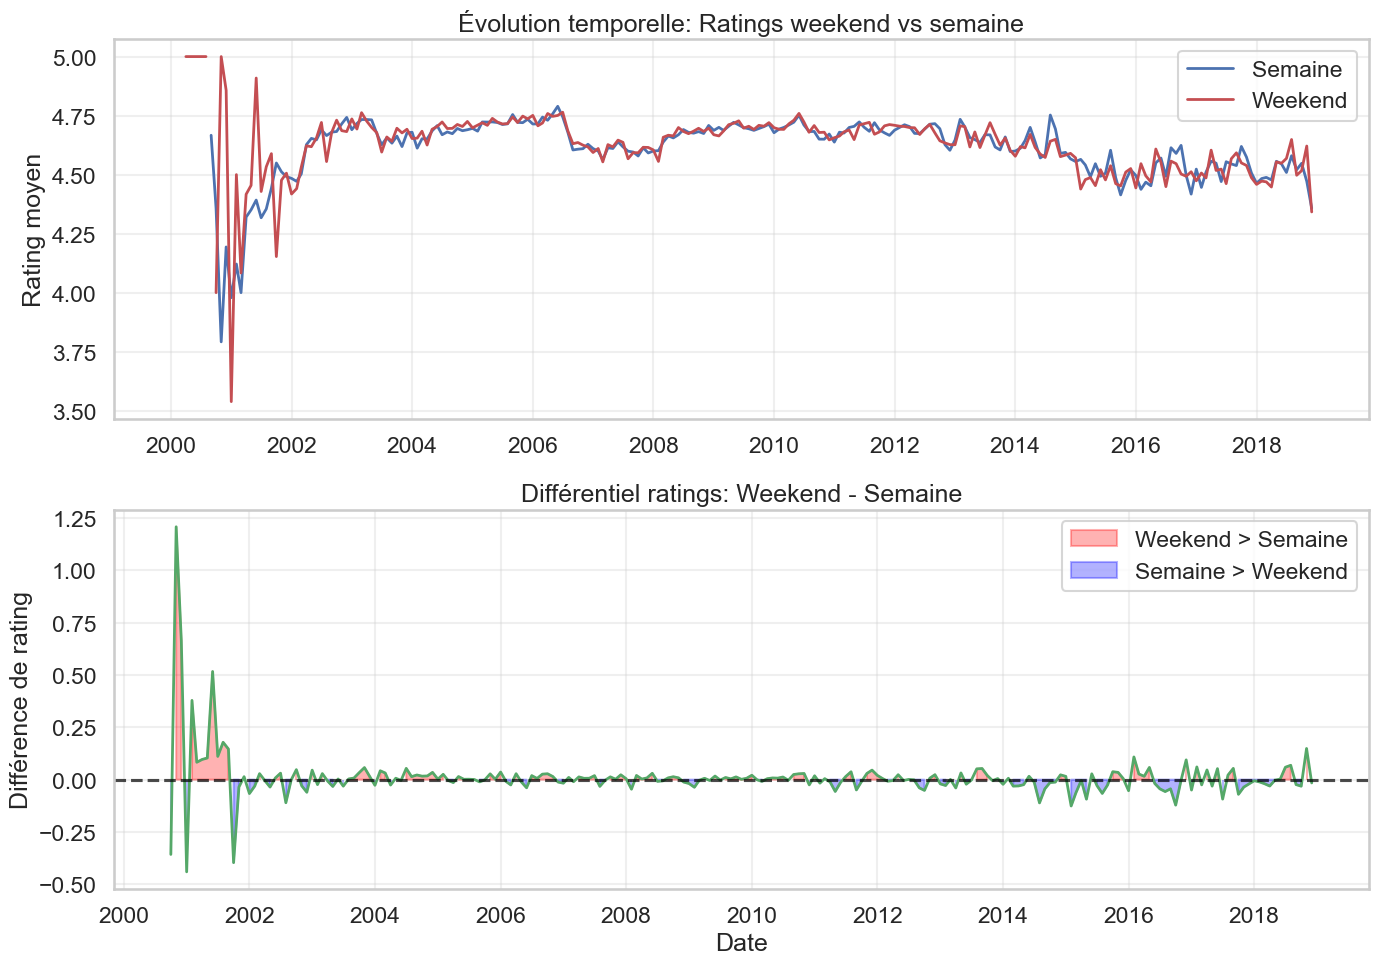

üìä Analyse du diff√©rentiel weekend-semaine:
   Moyenne: 0.0097
   M√©diane: 0.0024
   √âcart-type: 0.1198
   Min: -0.4403
   Max: 1.2083

üìà 118/219 mois (53.9%) avec ratings weekend > semaine


In [ ]:
# √âvolution du pattern weekend dans le temps
monthly_weekend = df_enriched.filter(pl.col("rating") > 0).group_by(["year", "month", "is_weekend"]).agg([
    pl.col("rating").mean().alias("mean_rating"),
    pl.len().alias("n_ratings")
]).to_pandas()

# Pivot pour avoir weekend/semaine en colonnes
weekend_evolution = monthly_weekend.pivot_table(
    index=['year', 'month'], 
    columns='is_weekend', 
    values='mean_rating', 
    fill_value=np.nan
).reset_index()

weekend_evolution.columns = ['year', 'month', 'semaine', 'weekend']
weekend_evolution['date'] = pd.to_datetime(weekend_evolution[['year', 'month']].assign(day=1))
weekend_evolution['diff_weekend_semaine'] = weekend_evolution['weekend'] - weekend_evolution['semaine']

# Graphique de l'√©volution temporelle
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# √âvolution des ratings weekend vs semaine
ax1.plot(weekend_evolution['date'], weekend_evolution['semaine'], 'b-', label='Semaine', linewidth=2)
ax1.plot(weekend_evolution['date'], weekend_evolution['weekend'], 'r-', label='Weekend', linewidth=2)
ax1.set_title('√âvolution temporelle: Ratings weekend vs semaine')
ax1.set_ylabel('Rating moyen')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Diff√©rentiel weekend - semaine
ax2.plot(weekend_evolution['date'], weekend_evolution['diff_weekend_semaine'], 'g-', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax2.fill_between(weekend_evolution['date'], weekend_evolution['diff_weekend_semaine'], 0, 
                 where=(weekend_evolution['diff_weekend_semaine'] > 0), color='red', alpha=0.3, label='Weekend > Semaine')
ax2.fill_between(weekend_evolution['date'], weekend_evolution['diff_weekend_semaine'], 0, 
                 where=(weekend_evolution['diff_weekend_semaine'] < 0), color='blue', alpha=0.3, label='Semaine > Weekend')
ax2.set_title('Diff√©rentiel ratings: Weekend - Semaine')
ax2.set_xlabel('Date')
ax2.set_ylabel('Diff√©rence de rating')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques du diff√©rentiel
valid_diffs = weekend_evolution['diff_weekend_semaine'].dropna()
print(f"üìä Analyse du diff√©rentiel weekend-semaine:")
print(f"   Moyenne: {valid_diffs.mean():.4f}")
print(f"   M√©diane: {valid_diffs.median():.4f}")
print(f"   √âcart-type: {valid_diffs.std():.4f}")
print(f"   Min: {valid_diffs.min():.4f}")
print(f"   Max: {valid_diffs.max():.4f}")

positive_months = (valid_diffs > 0).sum()
total_months = len(valid_diffs)
print(f"\nüìà {positive_months}/{total_months} mois ({positive_months/total_months*100:.1f}%) avec ratings weekend > semaine")